# Continued EDA/Modelling/Predictions

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from PredMetric.PMetrics import PredictionMetrics

plt.style.use('dark_background')

In [2]:
train = pd.read_csv("./interim_datasets/train_interim.csv")
kaggle = pd.read_csv("./interim_datasets/kaggle_interim.csv")

In [3]:
nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood","Condition 1","Condition 2","Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature"]
ordinal_cols = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", "Paved Drive", "Pool QC", "Fence"]
continuous_cols = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"]
discrete_cols = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom abvgr", "Kitchen abvgr", "totrms abvgrd", "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold" ,"Yr Sold"]

In [4]:
def convert(x):
    return x.lower().replace(" ", "_")

nominal_con_cols = [convert(x) for x in nominal_cols]
ordinal_con_cols = {convert(x):{} for x in ordinal_cols}
continuous_con_cols = [convert(x) for x in continuous_cols]
discrete_con_cols = [convert(x) for x in discrete_cols]

In [5]:
all_columns = list(train.filter(regex="dum")) + \
              list(ordinal_con_cols.keys()) + continuous_con_cols + \
              list(train.filter(regex="bin")) + \
              ["totrms_abvgrd", "fireplaces", "garage_yr_blt", "garage_cars", "mo_sold", "yr_sold", "full_bath"]

In [6]:
new_train = train

In [7]:
new_train["newhouse_sold_at_age"] = new_train["yr_sold"] - new_train["year_built"]
new_train["newhouse_sold_at_rage"] = new_train["yr_sold"] - new_train["year_remod/add"]
new_train['newmain_sqft']=new_train['gr_liv_area']+new_train['total_bsmt_sf']+new_train['garage_area']+new_train['enclosed_porch'] 
new_train['newsum_quals'] = new_train["overall_qual"]+new_train["exter_qual"]+new_train["bsmt_qual"]+new_train["kitchen_qual"]+new_train["garage_qual"]
new_train['newtot_bath']=new_train['full_bath']+new_train['half_bath']*0.5+new_train['bsmt_full_bath']+new_train['bsmt_half_bath']*0.5
new_train['newsqft_inter']=(new_train['newmain_sqft']*new_train['newsum_quals']*new_train['newtot_bath']).map(np.sqrt)
new_train['newrecent_build'] = (new_train['year_built']>=2000).astype(int)
all_columns_full =  all_columns + list(new_train.filter(regex="new"))

In [47]:
len(all_columns_full)

228

In [48]:
poly_revised_features = ['overall_qual overall_qual',
 'garage_area overall_qual',
 'gr_liv_area kitchen_qual',
 '1st_flr_sf overall_qual',
 'overall_qual total_bsmt_sf',
 'bin_total_baths bsmt_qual',
 '1st_flr_sf total_bsmt_sf',
 '1st_flr_sf dumnei_nridght',
 'gr_liv_area lot_area',
 'bsmt_cond bsmtfin_sf_1',
 'bsmt_exposure lot_area',
 '1st_flr_sf lot_area',
 'dumms__60 lot_area',
 'dumms__60 functional',
 'bsmt_exposure dumms__20',
 'bsmtfin_sf_1 dumms__20',
 'dumnei_noridge lot_area',
 'functional functional',
 'dumms__20 functional',
 'dumext_brkface overall_qual',
 'dumnei_grnhill lot_area',
 'dummis_tenc screen_porch',
 'dummis_tenc overall_qual',
 'dummis_tenc functional',
 'dummis_tenc kitchen_qual',
 'dummis_tenc dumnei_nwames',
 'dummis_tenc dumms__60',
 'dummis_tenc dummis_tenc',
 'bsmt_qual dummis_tenc',
 'bin_year_built dummis_tenc',
 'dummis_tenc garage_area',
 'bin_total_baths dummis_tenc',
 'dummis_tenc gr_liv_area',
 'dummis_tenc total_bsmt_sf',
 '1st_flr_sf dummis_tenc',
 'bsmtfin_sf_1 dummis_tenc',
 'dummis_tenc exter_qual',
 'bsmt_cond dummis_tenc',
 'dummis_tenc lot_area',
 'dummis_tenc mas_vnr_area',
 'bedroom_abvgr fireplaces',
 'half_bath half_bath',
 'low_qual_fin_sf open_porch_sf',
 '1st_flr_sf bedroom_abvgr',
 'kitchen_abvgr totrms_abvgrd',
 'bsmt_unf_sf garage_yr_blt',
 'bsmtfin_sf_1 year_built',
 'total_bsmt_sf yr_sold',
 'total_bsmt_sf year_remod/add',
 'gr_liv_area year_remod/add',
 'bedroom_abvgr garage_cars',
 'total_bsmt_sf year_built',
 'lot_area total_bsmt_sf',
 'bedroom_abvgr totrms_abvgrd']

In [49]:
make_poly = []
for p in poly_revised_features:
    cols = p.split(" ")
    make_poly.append([cols[0], cols[1], p])

In [50]:
for cols in make_poly:
    new_train[cols[2]] = new_train[cols[0]] * new_train[cols[1]]

In [51]:
all_columns_new = all_columns_full + poly_revised_features

In [9]:
# correlation_dict = {col : [] for col in all_columns_full}

In [10]:
# for col in correlation_dict:
#     y = new_train[col]
#     X = new_train[all_columns_full]
#     correlation_dict[col] = list(new_train[all_columns_full].corr()[[col]][new_train[all_columns_full].corr()[col].abs() > 0.50].sort_values(by=col, ascending=False).index)

In [11]:
# def product(mlst):
#     val = 1
#     for x in mlst:
#         val = val * x
#     return val 

# drop_columns = []
# for col in correlation_dict:
#     lst = correlation_dict[col]
#     if len(lst) > 1:
#         new_col = "new_" + col
#         new_train[new_col] = product([new_train[col] for col in lst])
#         drop_columns = drop_columns + [col for col in lst if col not in drop_columns]

# drop_columns.sort()
# # new_train = new_train.drop(columns=drop_columns)

In [12]:
new_train[list(new_train.filter(regex="new_"))].describe()

,new_dumms__20,new_dumms__45,new_dumms__50,new_dumms__60,new_dumms__75,new_dumms__80,new_dumms__85,new_dumms__90,new_dumms__120,new_dumms__160,...,new_garage_yr_blt,new_garage_cars,new_full_bath,new_newhouse_sold_at_age,new_newhouse_sold_at_rage,new_newmain_sqft,new_newsum_quals,new_newtot_bath,new_newsqft_inter,new_newrecent_build
count,2051.0,2051.000000,2051.000000,2051.0,2051.000000,2051.000000,2051.000000,2051.000000,2051.0,2051.000000,...,2051.0,2051.0,2.051000e+03,2051.0,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2051.0
mean,0.0,0.004876,0.096051,0.0,0.005363,0.041931,0.013652,0.036568,0.0,0.023891,...,0.0,0.0,6.170642e+13,0.0,3.550667e+14,1.379436e+26,1.020700e+30,8.917054e+13,3.791507e+30,0.0
std,0.0,0.069673,0.294733,0.0,0.073055,0.200480,0.116069,0.187743,0.0,0.152746,...,0.0,0.0,3.832101e+14,0.0,1.482419e+15,3.642835e+27,1.209716e+31,3.692525e+14,5.825763e+31,0.0
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-5.837280e+14,0.000000e+00,0.0
25%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,1.105832e+12,0.0,0.000000e+00,8.209764e+21,0.000000e+00,4.388489e+12,0.000000e+00,0.0
50%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,8.861910e+12,0.0,0.000000e+00,2.591192e+23,0.000000e+00,1.825634e+13,0.000000e+00,0.0
75%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,3.514533e+13,0.0,0.000000e+00,2.970122e+24,0.000000e+00,6.429936e+13,2.262999e+26,0.0
max,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,0.0,0.0,1.302541e+16,0.0,2.379279e+16,1.323752e+29,2.691501e+32,9.952722e+15,2.366589e+33,0.0


In [56]:
# for col in list(new_train.filter(regex="new_")):
#     if new_train[col].mean() > 100_000:
#         new_train[col] = np.sqrt(new_train[col])

In [57]:
# new_train['new_main_sqft']=new_train['gr_liv_area']+new_train['total_bsmt_sf']+new_train['garage_area']+new_train['enclosed_porch'] 
# new_train['new_sum_quals'] = new_train["overall_qual"]+new_train["exter_qual"]+new_train["bsmt_qual"]+new_train["kitchen_qual"]+new_train["garage_qual"]
# new_train['new_tot_bath']=new_train['full_bath']+new_train['half_bath']*0.5+new_train['bsmt_full_bath']+new_train['bsmt_half_bath']*0.5
# new_train['new_sqft_inter']=(new_train['new_main_sqft']*new_train['new_sum_quals']*new_train['new_tot_bath']).map(np.sqrt)
# new_train['recent_build'] = (new_train['year_built']>=2000).astype(int)
# new_train.columns

In [13]:
features = all_columns_full + list(new_train.filter(regex="new_"))
col = "log_saleprice"
new_train["log_saleprice"] = new_train["saleprice"].map(np.log)
nf = features + ["log_saleprice"]
new_train[nf].corr()[[col]][new_train[nf].corr()[col] >= 0.50].sort_values(by=col, ascending=False)

,log_saleprice
log_saleprice,1.000000
newsqft_inter,0.862721
newsum_quals,0.848076
overall_qual,0.822774
newmain_sqft,0.796352
exter_qual,0.690333
gr_liv_area,0.687774
kitchen_qual,0.681550
garage_cars,0.667168
newtot_bath,0.659341


In [64]:
# X = new_train[all_columns_new]
# y = new_train["saleprice"].map(np.log)
# ols_X = sm.add_constant(new_train[all_columns])
# model_ols = sm.OLS(y,ols_X).fit()
# model_ols.summary()

In [24]:
from sklearn.model_selection import GridSearchCV

In [84]:
X = new_train[all_columns_new]
y = new_train["saleprice"].map(np.log)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [73]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.7s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [74]:
grid.best_score_

-15013837.560758019

In [75]:
grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [76]:
grid.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
grid.error_score

'raise-deprecating'

In [78]:
new_train["salesprice_hat"] = np.exp(grid.predict(X))
new_train["salesprice_hat"].describe()

count      2051.000000
mean     180864.699383
std       77375.829797
min       14583.486480
25%      129637.846710
50%      161596.147412
75%      214419.353583
max      565140.709579
Name: salesprice_hat, dtype: float64

In [79]:
new_train["residuals"] = abs(new_train["saleprice"] - new_train["salesprice_hat"])
new_train.loc[new_train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
1,220000,226320.711502,6320.711502
4,138500,130846.634849,7653.365151
6,140000,141278.141529,1278.141529
7,142000,135362.322062,6637.677938
8,112500,107898.956132,4601.043868
...,...,...,...
2039,93900,87173.538362,6726.461638
2041,412500,419082.710255,6582.710255
2043,128000,133193.193821,5193.193821
2048,177000,186067.136494,9067.136494


In [87]:
np.sqrt(mean_squared_error(y_test, np.exp(grid.predict(X_test))))

197602.71395967185

In [88]:
np.sqrt(mean_squared_error(y_train, np.exp(grid.predict(X_train))))

196256.88545218925

In [90]:
mean_absolute_error(y_test, np.exp(grid.predict(X_test)))

182430.58188921757

In [91]:
mean_absolute_error(y_train, np.exp(grid.predict(X_train)))

180075.2055709836

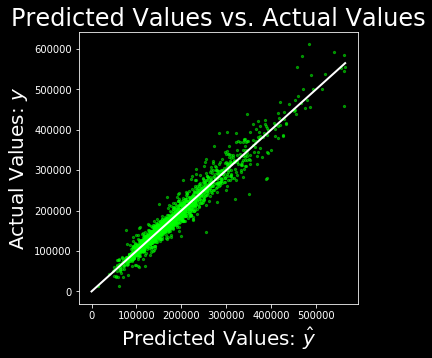

In [96]:
#Plotting 9th  LR prediction model
plt.figure(figsize=(5,5))

y_hat = np.exp(grid.predict(X))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, new_train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(y_hat)], [0, np.max(y_hat)], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

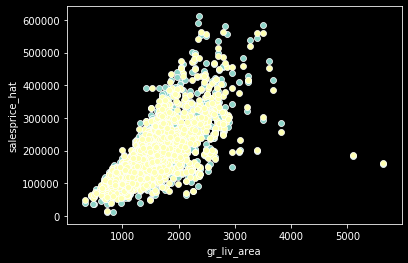

In [102]:
sns.scatterplot(new_train["gr_liv_area"], new_train["saleprice"])
sns.scatterplot(new_train["gr_liv_area"], new_train["salesprice_hat"])

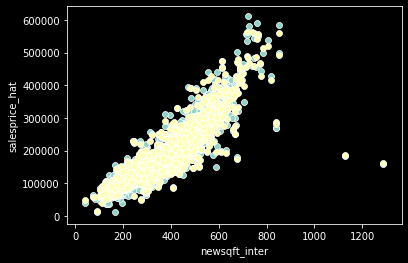

In [103]:
sns.scatterplot(new_train["newsqft_inter"], new_train["saleprice"])
sns.scatterplot(new_train["newsqft_inter"], new_train["salesprice_hat"])

In [61]:
# pm = PredictionMetrics(grid, X_train, X_test, y_train, y_test, True)
# pm.metric_df

In [62]:
grid.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)>

In [46]:
from sklearn.pipeline import Pipeline

In [65]:

# Instantiate a StandardScaler + kNN pipeline.
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression(),
    ('gs', ))
])

In [66]:

# Fit.
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [67]:

# Evaluate.
pipe.score(X_test, y_test)

-5.476640259095432e+23

In [68]:
pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('lr',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))],
 'verbose': False,
 'ss': StandardScaler(copy=True, with_mean=True, with_std=True),
 'lr': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__normalize': False}